# Impute Fuel Economy and Value

After merging fuel economy and value numbers, there is still missing data due to unmatched vehicles. Impute those missing values using MICE.

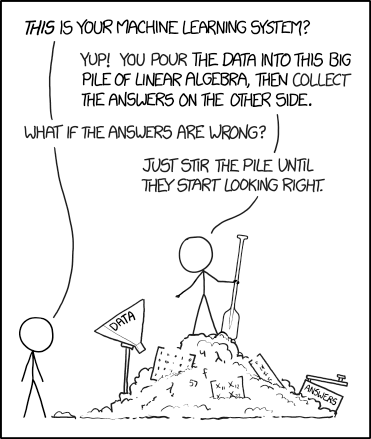
(xkcd, of course)


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
from statsmodels.imputation.mice import MICEData
import statsmodels.api as sm
import textlog
import matplotlib.pyplot as plt
text = textlog.textSetup(prefix='Imputation: ')

IMPUTATIONS = 10

In [2]:
vehicles = pd.read_csv('../data/vehicles_fuel_economy_value.csv', low_memory=False)
vehicles.loc[vehicles.OD_READ <= 0, 'OD_READ'] = np.nan
vehicles['logcombined'] = np.log(vehicles.combined)
vehicles['logod'] = np.log(vehicles.OD_READ.replace({0: np.nan}))
vehicles['urban'] = vehicles.HHURBRUR = 1
vehicles['logmileageannual'] = np.log(vehicles.BESTMILE.apply(lambda x: max(x, 1)))
vehicles['logvalue'] = np.log(vehicles.value)
vehicles['missingannual'] = vehicles.BESTMILE < 0

In [3]:
# figure out if a vehicle is the newest in the household
newest = vehicles.groupby('HOUSEID', as_index=False).agg({'VEHYEAR': max}).rename(columns={'VEHYEAR': 'hhnewveh'})
vehicles = vehicles.merge(newest, on='HOUSEID', how='left', validate='m:1')
vehicles['newestvehicle'] = vehicles.VEHYEAR == vehicles.hhnewveh

In [4]:
vehiclesWithDummies = sm.add_constant(pd.get_dummies(vehicles[[
    'makeName', 'VEHYEAR', 'kind', 'logod', 'logcombined', 'logvalue', 'urban', 'fuel', 'logmileageannual', 'missingannual', 'newestvehicle'
]]), has_constant='add').rename(columns=lambda x: x.replace(' ', '_').replace('-', '_'))

In [5]:
# Confirm that there are no missing values in any columns other than those we're imputing
nas = vehiclesWithDummies.apply(lambda x: np.any(pd.isnull(x)))
print(nas[nas])

logod          True
logcombined    True
logvalue       True
dtype: bool


In [6]:
vehiclesWithDummies.columns

Index(['const', 'VEHYEAR', 'logod', 'logcombined', 'logvalue', 'urban',
       'logmileageannual', 'missingannual', 'newestvehicle', 'makeName_Acura',
       'makeName_American_Motors_Corporation', 'makeName_Audi', 'makeName_BMW',
       'makeName_Buick', 'makeName_Cadillac', 'makeName_Chevrolet',
       'makeName_Chrysler', 'makeName_Dodge', 'makeName_Fiat', 'makeName_Ford',
       'makeName_Freightliner', 'makeName_GMC', 'makeName_Harley_Davidson',
       'makeName_Honda', 'makeName_Hummer', 'makeName_Hyundai',
       'makeName_Infiniti', 'makeName_International_Harvester/Navistar',
       'makeName_Isuzu', 'makeName_Jaguar', 'makeName_Jeep',
       'makeName_Kawasaki', 'makeName_Kia', 'makeName_Land_Rover',
       'makeName_Lexus', 'makeName_Lincoln', 'makeName_MG', 'makeName_Mazda',
       'makeName_Mercedes_Benz', 'makeName_Mercury', 'makeName_Mitsubishi',
       'makeName_Nissan', 'makeName_Oldsmobile', 'makeName_Other',
       'makeName_Other_Domestic', 'makeName_Other_Import', 

In [7]:
allMakes = ' + '.join([
    f'makeName_{c}' for c in ['Toyota',
     'Cadillac',
     'Chevrolet',
     'Infiniti',
     'Ford',
     'Honda',
     'Oldsmobile',
     'Lexus',
     'Nissan',
     'Mazda',
     'Jeep',
     'Subaru',
     'Chrysler',
     'Dodge',
     'Hyundai',
     'Acura',
     'Kia',
     'Buick',
     'Pontiac',
     'Volkswagen',
     'Audi',
     'Mercury',
     'GMC',
     'BMW',
     'Lincoln',
     'Mitsubishi',
     'Saturn',
     'Suzuki',
     'Mercedes_Benz',
     'Volvo',
     'Saab',
     'Porsche',
     'Hummer',
     'Fiat',
     'smart',
     'Scion',
     'Land_Rover',
     'Jaguar',
     'Isuzu',
     'Plymouth']])
allMakes

'makeName_Toyota + makeName_Cadillac + makeName_Chevrolet + makeName_Infiniti + makeName_Ford + makeName_Honda + makeName_Oldsmobile + makeName_Lexus + makeName_Nissan + makeName_Mazda + makeName_Jeep + makeName_Subaru + makeName_Chrysler + makeName_Dodge + makeName_Hyundai + makeName_Acura + makeName_Kia + makeName_Buick + makeName_Pontiac + makeName_Volkswagen + makeName_Audi + makeName_Mercury + makeName_GMC + makeName_BMW + makeName_Lincoln + makeName_Mitsubishi + makeName_Saturn + makeName_Suzuki + makeName_Mercedes_Benz + makeName_Volvo + makeName_Saab + makeName_Porsche + makeName_Hummer + makeName_Fiat + makeName_smart + makeName_Scion + makeName_Land_Rover + makeName_Jaguar + makeName_Isuzu + makeName_Plymouth'

## Do the imputation

TODO: make sure it's okay that logod appears on the RHS of logvalue
TODO: is 10 burnin/10 skip iterations sufficient?

In [8]:
mice = MICEData(vehiclesWithDummies)
# TODO redo with vehicle households
mice.set_imputer(
    'logod',
    'const + VEHYEAR + fuel_Diesel + kind_Van + kind_SUV + kind_Pickup + kind_Other_Truck + urban + logmileageannual + missingannual + newestvehicle')

mice.set_imputer(
    'logvalue',
    'const + VEHYEAR + fuel_Diesel + logod + kind_Van + kind_SUV + kind_Pickup + kind_Other_Truck +' + allMakes
)
mice.set_imputer(
    'logcombined',
    'const + VEHYEAR + fuel_Diesel + kind_Van + kind_SUV + kind_Pickup + kind_Other_Truck +' + allMakes
)


print('setup complete')
mice.update_all(10)
result = mice.data[['logod', 'logcombined', 'logvalue']].copy()

for i in range(IMPUTATIONS - 1):
    print(f'imputation {i}')
    mice.update_all(10)
    result += mice.data[['logod', 'logcombined', 'logvalue']].copy()
    
text('imputation complete')
    
result /= IMPUTATIONS # convert to mean
vehiclesWithDummies['logod'] = result['logod']
vehiclesWithDummies['OD_READ'] = np.exp(result.logod)
vehiclesWithDummies['logvalue'] = result['logvalue']
vehiclesWithDummies['value'] = np.exp(result['logvalue'])
vehiclesWithDummies['logcombined'] = result.logcombined
vehiclesWithDummies['combined'] = np.exp(result.logcombined)

setup complete


/Users/matthewc/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


imputation 0
imputation 1
imputation 2
imputation 3
imputation 4
imputation 5
imputation 6
imputation 7
imputation 8


In [9]:
vehiclesWithImputations = vehicles.join(
    vehiclesWithDummies[['OD_READ', 'combined', 'value']].rename(columns=lambda x: f'{x}_imputed')
)

In [10]:
vehiclesWithImputations.to_csv('../data/vehicles_fuel_economy_value_imputed.csv')

## Evaluate imputation quality

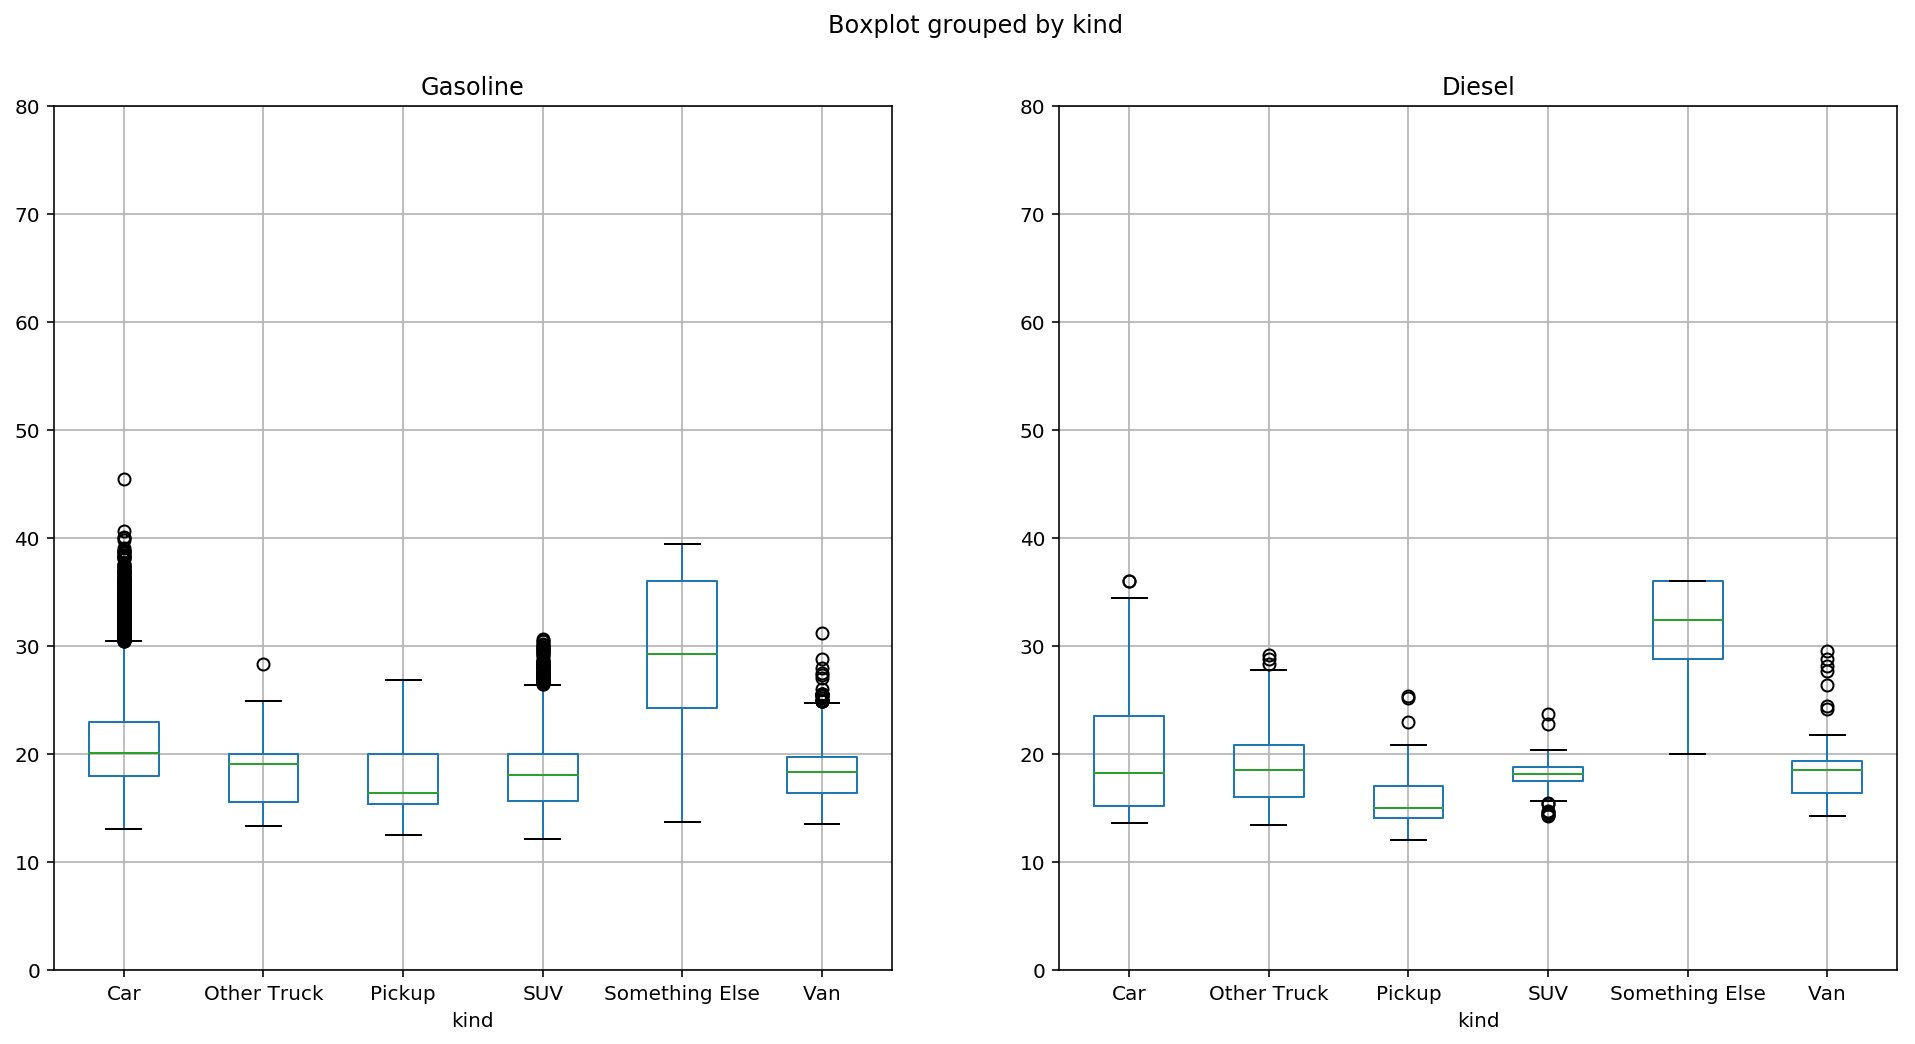

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
onlyImputations = vehiclesWithImputations[pd.isnull(vehiclesWithImputations.combined)]
for i, fuel in enumerate(['Gasoline', 'Diesel']):
    ax = axes[i]
    onlyImputations[onlyImputations.fuel == fuel].boxplot(column='combined_imputed', by='kind', ax=ax)
    ax.set_title(fuel)
    ax.set_ylim(0, 80)

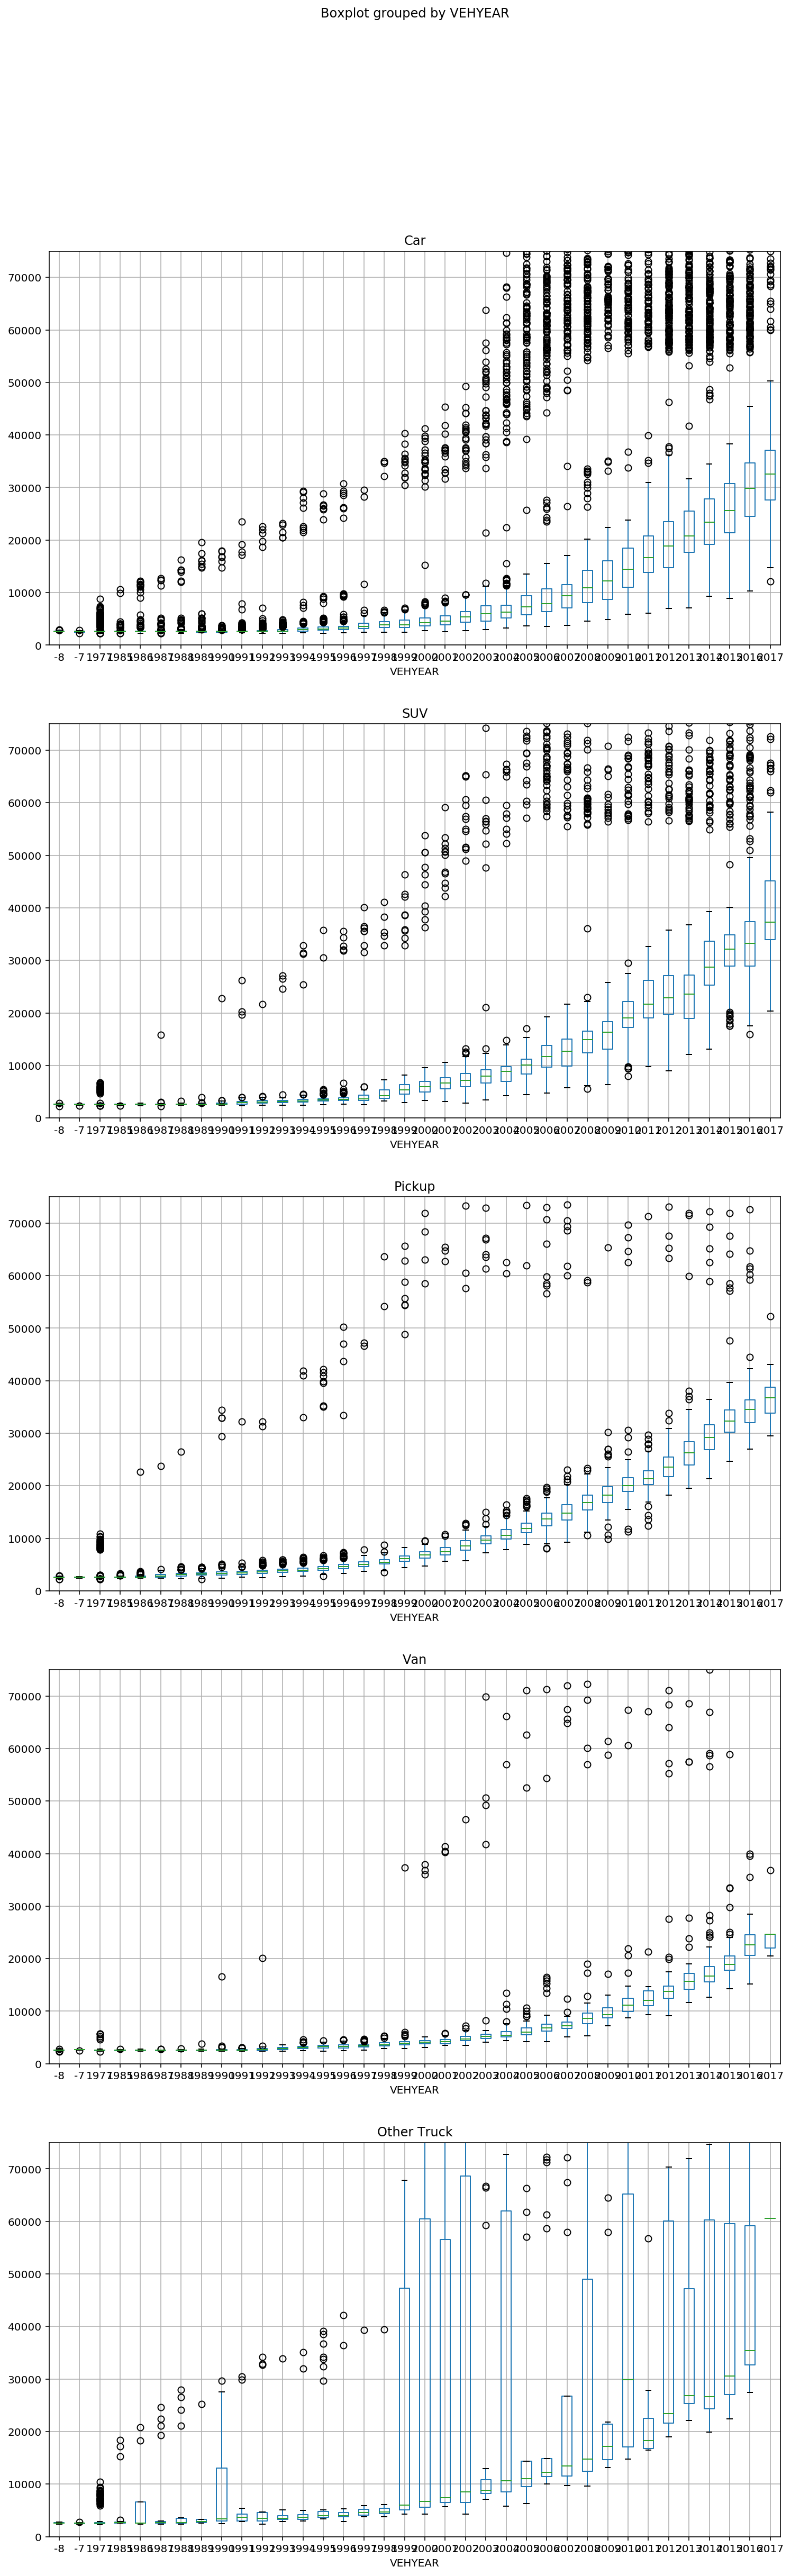

In [12]:
onlyImputed = vehiclesWithImputations.loc[pd.isnull(vehiclesWithImputations.value), ['VEHYEAR', 'value_imputed', 'kind']]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 40))
for i, k in enumerate(['Car', 'SUV', 'Pickup', 'Van', 'Other Truck']):
    #fig, ax = plt.subplot(3, 2, i + 1)
    vehs = onlyImputed[onlyImputed.kind == k]
    if len(vehs) < 10:
        continue
    ax = axes[i]
    vehs.boxplot(column='value_imputed', by='VEHYEAR', ax=ax)
    ax.set_title(k)
    ax.set_ylim(0, 75000)